## The code simulates robot movements on a grid, generates congestion data, and uses a 2-layer LSTM to predict future congestion. It visualizes actual vs predicted congestion to evaluate the model’s forecasting accuracy.

By: **Akhilesh Pant** (MCA)

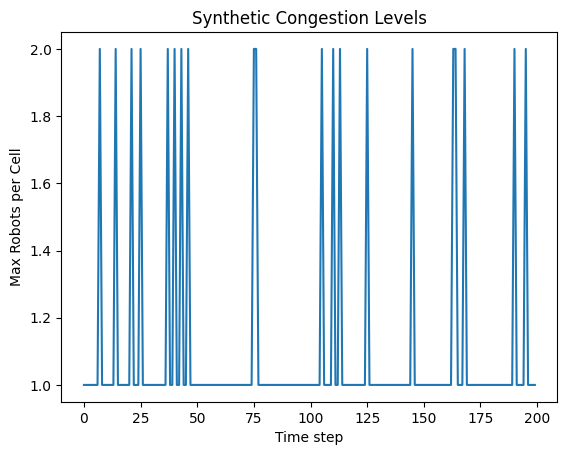

Epoch 10/50, Loss: 0.1063
Epoch 20/50, Loss: 0.1052
Epoch 30/50, Loss: 0.1052
Epoch 40/50, Loss: 0.1105
Epoch 50/50, Loss: 0.1004


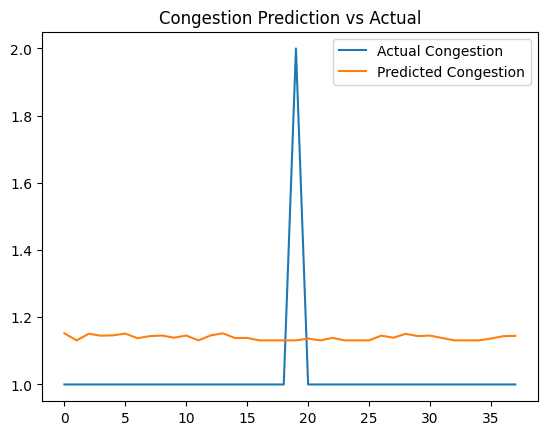

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# -----------------------------
# Generate Synthetic Congestion Data
# -----------------------------
def generate_synthetic_data(steps=100, num_cells=10, num_robots=5):
    """
    Generate synthetic time-series data representing congestion levels in each cell.
    Congestion = number of robots in a cell at each timestep
    """
    data = []
    for t in range(steps):
        # Random positions of robots
        positions = np.random.randint(0, num_cells, size=(num_robots, 2))
        heatmap = np.zeros((num_cells, num_cells))
        for x, y in positions:
            heatmap[x, y] += 1
        # Maximum robots in a cell = congestion measure
        congestion_level = np.max(heatmap)
        data.append(congestion_level)
    return np.array(data)

# Generate synthetic data
timesteps = 200
data = generate_synthetic_data(steps=timesteps)
plt.plot(data)
plt.title("Synthetic Congestion Levels")
plt.xlabel("Time step")
plt.ylabel("Max Robots per Cell")
plt.show()

# -----------------------------
# Prepare Data for LSTM
# -----------------------------
class CongestionDataset(Dataset):
    def __init__(self, data, seq_length=10):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_length]
        y = self.data[idx+self.seq_length]
        return torch.tensor(x, dtype=torch.float32).unsqueeze(-1), torch.tensor(y, dtype=torch.float32)

seq_length = 10
dataset = CongestionDataset(data, seq_length)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# -----------------------------
# LSTM Model
# -----------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take the last timestep
        out = self.fc(out)
        return out

model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# -----------------------------
# Train LSTM Model
# -----------------------------
epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

# -----------------------------
# Evaluate Model
# -----------------------------
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        y_pred = model(x_batch)
        predictions.extend(y_pred.squeeze().numpy())
        actuals.extend(y_batch.numpy())

plt.plot(actuals, label="Actual Congestion")
plt.plot(predictions, label="Predicted Congestion")
plt.legend()
plt.title("Congestion Prediction vs Actual")
plt.show()



---

### **1️⃣ What the code is doing**

* It **simulates robots moving randomly** on a grid.
* Measures **congestion** at each timestep → how crowded any cell is.
* Trains an **LSTM (a type of neural network for sequences)** to **predict congestion in the next timestep** based on past congestion data.
* Finally, it **plots the predicted congestion vs actual congestion** to see how well the model predicts.

---

### **2️⃣ Purpose**

* To **predict congestion levels** in a system (like robots in a warehouse or vehicles on a road).
* Helps in understanding **when and where congestion might happen**.
* Uses machine learning (LSTM) for **time-series prediction**.

---

### **3️⃣ What kind of results you get**

1. **A plot of synthetic congestion** over time (shows how crowded the cells are at each timestep).
2. **A trained LSTM model** that can predict congestion for the next timestep.
3. **A comparison plot** showing:

   * Actual congestion
   * Predicted congestion by the model

This lets you see if the model is **accurately predicting congestion trends**.

---


## **Line By Line Explaination** 
---

## **1️⃣ Import Libraries**

```python
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
```

* `numpy`: For math and arrays.
* `matplotlib.pyplot`: For plotting graphs.
* `torch` & `torch.nn`: To create and train neural networks.
* `Dataset, DataLoader`: Helps to organize data for training.

---

## **2️⃣ Generate Synthetic Congestion Data**

```python
def generate_synthetic_data(steps=100, num_cells=10, num_robots=5):
    data = []
    for t in range(steps):
        positions = np.random.randint(0, num_cells, size=(num_robots, 2))
        heatmap = np.zeros((num_cells, num_cells))
        for x, y in positions:
            heatmap[x, y] += 1
        congestion_level = np.max(heatmap)
        data.append(congestion_level)
    return np.array(data)
```

* `steps`: Number of time steps to simulate.
* `num_cells`: Grid size (e.g., 10x10).
* `num_robots`: Number of robots moving randomly.
* Loop `for t in range(steps)`: Simulate each timestep.
* `positions = np.random.randint(...)`: Randomly put robots on the grid.
* `heatmap = np.zeros(...)`: Create empty grid.
* `heatmap[x, y] += 1`: Count how many robots are in each cell.
* `congestion_level = np.max(heatmap)`: Maximum robots in any cell → congestion.
* `data.append(congestion_level)`: Store congestion for this timestep.

```python
timesteps = 200
data = generate_synthetic_data(steps=timesteps)
plt.plot(data)
plt.title("Synthetic Congestion Levels")
plt.xlabel("Time step")
plt.ylabel("Max Robots per Cell")
plt.show()
```

* Generates congestion data for **200 timesteps**.
* Plots congestion over time.

---

## **3️⃣ Prepare Data for LSTM**

```python
class CongestionDataset(Dataset):
    def __init__(self, data, seq_length=10):
        self.data = data
        self.seq_length = seq_length
```

* `seq_length`: Number of past timesteps to use for predicting the next.

```python
    def __len__(self):
        return len(self.data) - self.seq_length
```

* Returns **number of samples** for training.

```python
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_length]
        y = self.data[idx+self.seq_length]
        return torch.tensor(x, dtype=torch.float32).unsqueeze(-1), torch.tensor(y, dtype=torch.float32)
```

* `x`: Sequence of past `seq_length` congestion values.
* `y`: Next timestep congestion value.
* `unsqueeze(-1)`: Make it shape compatible for LSTM.

```python
seq_length = 10
dataset = CongestionDataset(data, seq_length)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)
```

* Split dataset **80% train, 20% test**.
* Load data in **batches of 16** for training/testing.

---

## **4️⃣ Define LSTM Model**

```python
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
```

* `input_size=1`: Each timestep has 1 feature (congestion).
* `hidden_size=32`: Number of LSTM neurons.
* `num_layers=2`: Stack 2 LSTM layers.
* `fc`: Linear layer to convert LSTM output to final prediction.

```python
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last timestep
        out = self.fc(out)
        return out
```

* Pass sequence `x` through LSTM.
* Take output of **last timestep**.
* Pass it through linear layer → predicted congestion.

---

## **5️⃣ Train LSTM**

```python
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
```

* `MSELoss`: Measures error between prediction and actual value.
* `Adam`: Optimizer to update model weights.

```python
epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")
```

* Loop over **50 epochs** (full training cycles).
* Forward pass → compute loss → backpropagation → update weights.
* Print loss every 10 epochs to see progress.

---

## **6️⃣ Evaluate Model**

```python
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        y_pred = model(x_batch)
        predictions.extend(y_pred.squeeze().numpy())
        actuals.extend(y_batch.numpy())
```

* Switch model to **evaluation mode**.
* Predict congestion on test data without updating weights.

```python
plt.plot(actuals, label="Actual Congestion")
plt.plot(predictions, label="Predicted Congestion")
plt.legend()
plt.title("Congestion Prediction vs Actual")
plt.show()
```

* Plots **predicted vs actual congestion** to see model accuracy.

---

### ✅ **Summary in Super Simple Words**

1. Simulate robots moving randomly → get congestion numbers.
2. Convert congestion numbers into sequences for LSTM.
3. Train LSTM to predict **next congestion value** from past values.
4. Test and plot predictions vs actual congestion.

---




## **LSTM Congestion Prediction: 100 Q&A for Interviews**

---

## **EASY QUESTIONS (30)**

1. What library is used for numerical operations in this code?
   **Answer:** `numpy`

2. What library is used for plotting graphs?
   **Answer:** `matplotlib.pyplot`

3. Which library is used to create the neural network?
   **Answer:** `torch`

4. What type of data is generated by `generate_synthetic_data`?
   **Answer:** Time-series congestion data

5. What does `np.random.randint(0, num_cells, size=(num_robots, 2))` do?
   **Answer:** Randomly assigns robots to grid positions

6. How is congestion measured in the code?
   **Answer:** Maximum number of robots in a cell

7. What type of plot is used to visualize congestion?
   **Answer:** Line plot

8. What is `seq_length` in LSTM dataset?
   **Answer:** Number of past timesteps used to predict the next value

9. What does `unsqueeze(-1)` do?
   **Answer:** Adds a feature dimension for LSTM input

10. What is the purpose of `DataLoader`?
    **Answer:** Load dataset in batches for training/testing

11. What is the batch size used in this code?
    **Answer:** 16

12. Which optimizer is used for LSTM training?
    **Answer:** Adam

13. Which loss function is used?
    **Answer:** Mean Squared Error (`nn.MSELoss`)

14. How many epochs are used for training?
    **Answer:** 50

15. What does `model.train()` do?
    **Answer:** Sets the model in training mode

16. What does `model.eval()` do?
    **Answer:** Sets the model in evaluation mode

17. What does `torch.no_grad()` mean?
    **Answer:** Disables gradient computation for evaluation

18. What does `y_pred.squeeze()` do?
    **Answer:** Removes extra dimensions from predictions

19. How is the dataset split?
    **Answer:** 80% training, 20% testing

20. What does `random_split` do?
    **Answer:** Splits dataset into train and test sets randomly

21. What does `plt.legend()` do?
    **Answer:** Shows labels for multiple plots

22. What shape does LSTM expect for input?
    **Answer:** `(batch_size, sequence_length, features)`

23. What does `self.fc(out)` in LSTM do?
    **Answer:** Maps LSTM output to final prediction

24. How many layers are used in LSTM?
    **Answer:** 2

25. How many features per timestep in LSTM?
    **Answer:** 1 (congestion value)

26. What does `np.max(heatmap)` represent?
    **Answer:** Maximum congestion at that timestep

27. How is training loss updated?
    **Answer:** Accumulate `loss.item()` per batch

28. What does `optimizer.zero_grad()` do?
    **Answer:** Clears old gradients before backpropagation

29. What does `loss.backward()` do?
    **Answer:** Computes gradients for backpropagation

30. What does `optimizer.step()` do?
    **Answer:** Updates model weights using gradients

---

## **MODERATE QUESTIONS (40)**

31. Why do we use LSTM instead of a regular NN?
    **Answer:** LSTM handles sequential/time-series data and remembers past information

32. How do we convert congestion data into sequences for LSTM?
    **Answer:** Using a custom Dataset class with `seq_length` slices

33. Why do we take the last timestep output from LSTM?
    **Answer:** We want the prediction for the next value in the sequence

34. Explain the difference between `train()` and `eval()` in PyTorch.
    **Answer:** `train()` enables dropout/batchnorm; `eval()` disables them

35. What is the difference between `nn.Linear` and `nn.LSTM`?
    **Answer:** LSTM handles sequences; Linear is a fully connected layer

36. How do we know if the model is overfitting?
    **Answer:** Training loss low but test loss high

37. Why do we use `torch.tensor(..., dtype=torch.float32)`?
    **Answer:** LSTM requires float tensors as input

38. What happens if `seq_length` is too small?
    **Answer:** Model may not capture enough past information

39. What happens if `seq_length` is too large?
    **Answer:** Training may be slower and harder to converge

40. How does `DataLoader(shuffle=True)` help?
    **Answer:** Prevents model from learning order bias

41. What is the shape of `y_batch` in training?
    **Answer:** `(batch_size,)`

42. Why do we use `batch_first=True` in LSTM?
    **Answer:** So input shape is `(batch, seq_len, features)`

43. How do we evaluate model accuracy visually?
    **Answer:** Plot predicted vs actual values

44. What does `extend()` do in predictions list?
    **Answer:** Adds elements of a batch to the list

45. Can LSTM predict multiple steps ahead?
    **Answer:** Yes, recursively or using sequence-to-sequence models

46. Why do we use `MSELoss` instead of `CrossEntropyLoss`?
    **Answer:** MSELoss is for regression, CrossEntropyLoss is for classification

47. What is the role of `hidden_size`?
    **Answer:** Determines the memory capacity of LSTM

48. How can you improve the model accuracy?
    **Answer:** More data, tune hyperparameters, increase hidden\_size/layers

49. Why do we use random robot positions?
    **Answer:** To simulate realistic congestion scenarios

50. How is congestion data normalized in this code?
    **Answer:** It isn’t; values are raw counts

51. What will happen if `num_robots > num_cells**2`?
    **Answer:** Multiple robots occupy same cell → higher congestion

52. What is the difference between `torch.nn.LSTM` and `torch.nn.GRU`?
    **Answer:** GRU is simpler, fewer gates, faster to train

53. Why do we need `train_loader` and `test_loader` separately?
    **Answer:** To train on one set and evaluate on unseen data

54. Can we use CNN for this task?
    **Answer:** Possible, but LSTM is better for sequences

55. How is the dataset length calculated in `__len__()`?
    **Answer:** `len(data) - seq_length`

56. What would happen if we forget `unsqueeze(-1)`?
    **Answer:** Shape mismatch error in LSTM input

57. How do we prevent overfitting?
    **Answer:** Dropout, more data, early stopping, smaller network

58. What does `optimizer = torch.optim.Adam(...)` do?
    **Answer:** Chooses how to update weights to minimize loss

59. What does `loss.item()` return?
    **Answer:** Python float of the loss value

60. What does `torch.no_grad()` prevent?
    **Answer:** Prevents gradient computation → saves memory

61. How does the model know which value to predict?
    **Answer:** It predicts the next timestep from past sequence

62. How is the dataset split reproducibly?
    **Answer:** By setting a random seed (not in this code)

63. Why do we plot both predicted and actual values?
    **Answer:** To visually assess prediction accuracy

64. What is the purpose of `hidden_size` vs `num_layers`?
    **Answer:** `hidden_size` = neurons per layer, `num_layers` = depth of LSTM

65. How do you convert numpy array to torch tensor?
    **Answer:** `torch.tensor(numpy_array, dtype=torch.float32)`

66. What does `batch_size` affect?
    **Answer:** Memory usage, training speed, stability

67. Why do we shuffle training data?
    **Answer:** To reduce bias from sequential ordering

68. How is `epoch_loss` calculated?
    **Answer:** Sum of batch losses divided by number of batches

69. How do we save a trained model?
    **Answer:** `torch.save(model.state_dict(), 'model.pth')`

70. How do we load a saved model?
    **Answer:** `model.load_state_dict(torch.load('model.pth'))`

---

## **HARD QUESTIONS (30)**

71. Explain why LSTM uses gates and memory cells.
    **Answer:** To control what to remember, forget, and output → solves long-term dependency problem

72. How would you modify the code to predict multiple future timesteps?
    **Answer:** Use sequence-to-sequence LSTM or recursive predictions

73. How to implement normalization for congestion data?
    **Answer:** `(data - min) / (max - min)`

74. How would you tune hyperparameters?
    **Answer:** Grid search or random search for hidden\_size, learning\_rate, seq\_length, batch\_size

75. How does backpropagation through time (BPTT) work in LSTM?
    **Answer:** Gradients are propagated backward through timesteps to update weights

76. Why might `nn.MSELoss()` be insufficient for extreme congestion peaks?
    **Answer:** MSE penalizes large errors more, but may still underfit rare peaks

77. How can we include robot velocity in the input features?
    **Answer:** Expand input size to multiple features `(x, y, velocity)`

78. How to handle missing congestion data in time series?
    **Answer:** Interpolation, forward-fill, or imputation

79. What is the effect of too large `hidden_size`?
    **Answer:** Overfitting, higher memory usage, slower training

80. How would you visualize hidden states of LSTM?
    **Answer:** Extract `h_n` from LSTM and plot over time

81. How does sequence length affect memory usage?
    **Answer:** Longer sequences → more computation and GPU memory

82. How to modify LSTM for multi-grid congestion prediction?
    **Answer:** Increase features for each cell or use ConvLSTM

83. Explain why `batch_first=True` is important.
    **Answer:** Aligns input shape `(batch, seq_len, features)` to PyTorch expectation

84. How would you implement early stopping?
    **Answer:** Monitor validation loss → stop training if loss doesn’t improve for N epochs

85. How do you implement dropout in LSTM?
    **Answer:** Use `nn.LSTM(..., dropout=0.2)`

86. Explain vanishing gradient problem and how LSTM solves it.
    **Answer:** Gradients shrink over time → LSTM gates preserve important info

87. How can we use this model for real robot traffic control?
    **Answer:** Feed real-time congestion → predict next step → reroute robots

88. How to save both model and optimizer state?
    **Answer:** `torch.save({'model': model.state_dict(), 'optimizer': optimizer.state_dict()}, 'checkpoint.pth')`

89. Explain sequence-to-one vs sequence-to-sequence in LSTM.
    **Answer:** Seq-to-one → predict single next value; seq-to-seq → predict entire future sequence

90. How can we make predictions faster on GPU?
    **Answer:** Batch predictions, `torch.no_grad()`, use `model.eval()`

91. How to add multiple congestion features per cell?
    **Answer:** Increase input\_size → `[max_robots, avg_robots, congestion_rate]`

92. What would happen if `shuffle=False`?
    **Answer:** Model may learn temporal order bias → worse generalization

93. Explain exploding gradient and mitigation techniques.
    **Answer:** Gradients too large → clip gradients using `torch.nn.utils.clip_grad_norm_`

94. How do you implement a learning rate scheduler?
    **Answer:** `torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)`

95. How to extend this model for 3D congestion prediction?
    **Answer:** Use 3D grid features → possibly ConvLSTM

96. How would you handle multiple robots with different priorities?
    **Answer:** Add priority as feature, weight congestion by priority

97. How do you evaluate model quantitatively besides plots?
    **Answer:** Compute RMSE, MAE, R² score

98. How to adapt the model for real-time prediction?
    **Answer:** Use sliding window sequences with latest data

99. How to implement teacher forcing in multi-step prediction?
    **Answer:** Feed actual previous timestep as input instead of predicted value

100. How to combine LSTM with reinforcement learning for congestion control?
     **Answer:** LSTM predicts congestion → RL agent chooses optimal robot moves → reward = reduced congestion

---

